In [20]:
#Libraries required
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import pca
import scipy.sparse.linalg as la
from scipy.sparse import csr_matrix
import scipy
import scipy.sparse as sps
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import random
import sys 

#### Objective function
The following function computes the objective function given a clustering result.

In [21]:
def obj_func(graph,clusters):
    n_partition = max(clusters)+1
    n_vert = len(clusters)
    
    nodes_in_cluster = [0.0]*n_partition
    edge_out=[0.0]*n_partition #Array to compute number of edges moving out of a cluster to another
    
    for node in range(n_vert):
        nodes_in_cluster[clusters[node]] += 1
        for n in graph.neighbors(node):
                if(clusters[n]!=clusters[node]):
                    edge_out[clusters[node]]+=1
    #print("edge outs:", np.array(edge_out))
    phi = np.sum(np.array(edge_out)/np.array(nodes_in_cluster)) 
    
    return phi

The following function saves the results in the proper format

In [3]:
def save_in_file(f_name,clusters):
    f= open("results//"+f_name+".txt","w+")
    for i in range(len(clusters)):
        str_out = ""+str(i)+" "+str(clusters[i])+"\n"
        f.write(str_out)
        
#save_in_file(f_name,clusters)

##### Loading the graph, computing adjacency and laplacian
Let's process the text file and create a graph along with its adjacency and laplacian matrices. The first part of the following are the parameters that need to be tuned.

In [4]:
# The graphs
f_name = "ca-GrQc.txt"
#f_name = "ca-AstroPh.txt"
#f_name = "ca-CondMat.txt"

# normalizing the eigenvectrs (each row sum up to one)
normalize_eigvec = False

# normalizing the laplacian
normalized_laplac = False #THIS SHOULD BE FALSE IN THE CURRENT IMPLEMENTATION

#Reading graph file into csv file- contains only edges
f=open(f_name) 
graph=np.array(pd.read_csv(f,sep=' ',header=None,skiprows=1))

#reading the number of vertices,edges and partitions required
with open(f_name) as f: 
    first_line = f.readline()
graph_key=[int(s) for s in first_line.split() if s.isdigit()]

n_vert=graph_key[0]
n_edge=graph_key[1]
n_partition=graph_key[2]

# number of eigenvectors to be used
dim = n_partition # sometimes this should be modified 

print("Graph ", f_name)
print("Number of nodes: ", n_vert, ", Number of edges: ", n_edge, ", Number of partitions: ", n_partition)
print("Considerd dimension: ", dim, ", normalized laplace:", normalized_laplac, ", normalize eigvec:", normalize_eigvec)

#Constructing graph
G=nx.Graph()
G.add_edges_from(graph)

#compute adjacency matrix
adj_mat = nx.adjacency_matrix(G)
n,m = adj_mat.shape
diags = adj_mat.sum(axis=1)
D = sps.spdiags(diags.flatten(), [0], m, n, format='csr')

#Computing laplacian 
if normalized_laplac: #DO NOT USE THIS FOR NOW
    inv_D = scipy.sparse.linalg.inv(D)
    L1 = csr_matrix.sqrt(D).multiply(adj_mat)
    L = L1.multiply(csr_matrix.sqrt(inv_D))
    #L=scipy.sparse.csgraph.laplacian(G, normed=True, return_diag=False, use_out_degree=False)
    #L=nx.normalized_laplacian_matrix(G)
else: #USE THIS FOR NOW
    L = D - adj_mat
    #L = scipy.sparse.csgraph.laplacian(G, normed=False, return_diag=False, use_out_degree=False
    #L=nx.laplacian_matrix(G)

L=csr_matrix.astype(L,dtype='f')

# Computing eigen vectors
eig_val, X=la.eigsh(L,dim,which='SM') 

if normalize_eigvec == True:
    #sum_over_rows = np.sum(X,1)
    for i in range(n_vert):
        #X[i,:] = X[i,:]/sum_over_rows[i] 
        X[i,:] = X[i,:]/np.linalg.norm(X[i,:]) # norm 1 normalization

Graph  ca-GrQc.txt
Number of nodes:  4158 , Number of edges:  13428 , Number of partitions:  2
Considerd dimension:  2 , normalized laplace: False , normalize eigvec: False


#### Dummy plotting
Let's try to plot the data in two dimensions.

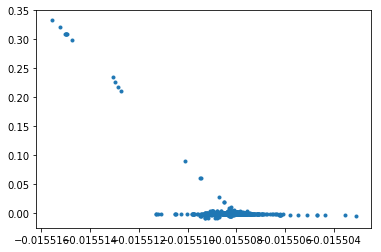

In [5]:
_, data=la.eigsh(L,2,which='SM') 
plt.plot(data[:,0],data[:,1],'.')

#### Random clustering baseline
Let's first try a random cluster assignment baseline. This would give us an idea about the error when clusters have roughly the same size

In [6]:
# compute error function for random assignment baseline
print("Random error:")
clusters_rnd = np.array([random.randint(0,n_partition-1) for i in range(n_vert)])
print(obj_func(G,clusters_rnd))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters_rnd==i) for i in range(n_partition)]
print(nodes_in_cluster)

Random error:
6.501240104613004
Number of nodes in each cluster:
[2084, 2074]


#### K-means baseline
Let's try K-means as a baseline.

In [30]:
# Computing k-means
#kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
km=KMeans(n_clusters=n_partition,max_iter=5000) #, init="k-means++",n_init=100
km.fit_predict(X)

# compute error function for k-means baseline
print("K-means (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,km.labels_))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(km.labels_==i) for i in range(n_partition)]
print(nodes_in_cluster)
#save_in_file(f_name,km.labels_)

K-means (baseline) error with 2 dimensions:


IndexError: index 4016 is out of bounds for axis 0 with size 950

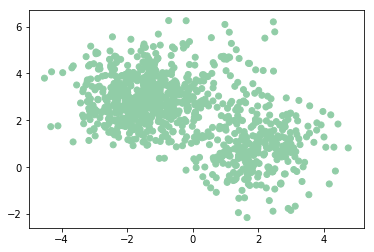

In [29]:
from random import randint
data_colors = []
for i in range(n_partition):
    data_colors.append('#%06X' % randint(0, 0xFFFFFF))
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in km.labels_])

#### Spectral clustering baseline
Let's try Spectral clustering (https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) to see if it works better. This algorithm uses the adjacency matrix as an input and uses a label assignment strategies (e.g., K-means) on a low dimensional representation of the matrix. 

In [9]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_partition, affinity='precomputed', n_init=100, assign_labels='discretize')
#Alternative parameterazations: assign_labels="kmeans", assign_labels="discretize"
sc.fit_predict(adj_mat) 
print("Spectral Clustering error using adjacency matrix:")
print(obj_func(G,sc.labels_))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(sc.labels_==i) for i in range(n_partition)]
print(nodes_in_cluster)

Spectral Clustering error using adjacency matrix:
5.478612405190005
Number of nodes in each cluster:
[4101, 57]


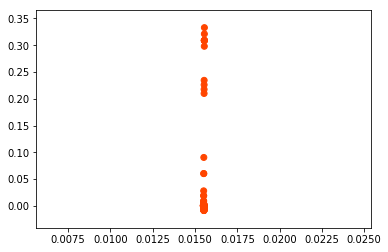

In [59]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in sc.labels_])

#### Modified K-means 
Let's implement our own K-means and then modify it to force the clusters to be balanced. There are usually two sets of functions implemented. The _plus methods use the K++ initialization for the centeroids.

In [22]:
# Useful functions from https://www.geeksforgeeks.org/ml-k-means-algorithm/

def distance(p1, p2): 
    return np.sum((p1 - p2)**2) 

# initialisation algorithm K++
def initialize(data, k): 
    ''' 
    intialized the centroids for K-means++ 
    inputs: 
        data - numpy array of data points 
        k - number of clusters  
    '''
    ## initialize the centroids list and add 
    ## a randomly selected data point to the list 
    centroids = [] 
    centroids.append(data[np.random.randint( 
            data.shape[0]), :]) 
   
    ## compute remaining k - 1 centroids 
    for c_id in range(k - 1): 
          
        ## initialize a list to store distances of data 
        ## points from nearest centroid 
        dist = [] 
        for i in range(data.shape[0]): 
            point = data[i, :] 
            d = sys.maxsize 
              
            ## compute distance of 'point' from each of the previously 
            ## selected centroid and store the minimum distance 
            for j in range(len(centroids)): 
                temp_dist = distance(point, centroids[j]) 
                d = min(d, temp_dist) 
            dist.append(d) 
              
        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist) 
        next_centroid = data[np.argmax(dist), :] 
        centroids.append(next_centroid) 
        dist = [] 
    return centroids 

In [61]:
def k_means_plus(X, n_partition, num_iters):    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    
    #Initialize centeriods using ++ method
    centroids = initialize(X, n_partition)
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)
        
        #assign clusters
        clusters = np.zeros(n_vert,dtype=np.int32)
        for i in range(n_vert):
            clusters[i] = np.argmin([np.linalg.norm(X[i] - centroids[j]) for j in range(n_partition)])
        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        k_means_errors.append(obj_func(G,clusters))
        
    return centroids,clusters,k_means_errors

In [62]:
def k_means(X, n_partition, num_iters):    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    
    #Assign data to random clusters
    clusters = np.array([random.randint(0,n_partition-1) for i in range(n_data)])
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)
        
        k_means_errors.append(obj_func(G,clusters))
        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        
        #assign clusters
        clusters = np.zeros(n_vert,dtype=np.int32)
        for i in range(n_vert):
            clusters[i] = np.argmin([np.linalg.norm(X[i] - centroids[j]) for j in range(n_partition)])
        
    return centroids,clusters,k_means_errors

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
K-means_ours (baseline) error with 2 dimensions:
8.8589001447178
Number of nodes in each cluster:
[4146, 12]


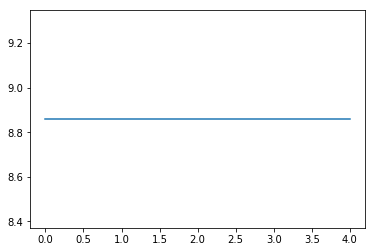

In [64]:
#centroids, clusters, errs = k_means(X, n_partition, num_iters=10)
centroids, clusters, errs = k_means_plus(X, n_partition, num_iters=5)

plt.plot(errs)
# compute error function for k-means baseline
print("K-means_ours (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,clusters))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters==i) for i in range(n_partition)]
print(nodes_in_cluster)
#print("The final cluster mean values are:",centroids)

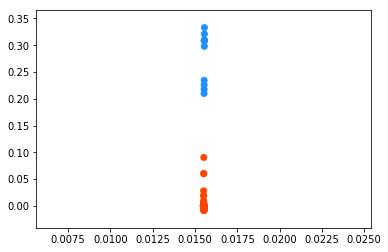

In [65]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])

In the first modification, we assume that the size of each cluster cannot be more than n_data/n_partition when we are assigning data points to clusters in a standard K-means algorithm.

In [66]:
def k_means_modified1_plus(X, n_partition, num_iters):    
    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    max_cluster_size = n_data/n_partition
    
    #Initialize centeriods using ++ method
    centroids = initialize(X, n_partition)
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)

        #assign clusters
        data_per_cluster = np.zeros(n_partition)
        clusters = np.zeros(n_data,dtype=np.int32)
        for i in range(n_data):
            dist_to_cluster = [np.linalg.norm(X[i] - centroids[j]) for j in range(n_partition)]
            close_clusters = np.argsort(dist_to_cluster)
            assigned_flag = False
            for j in range(n_partition):
                if  assigned_flag == False and data_per_cluster[close_clusters[j]] < max_cluster_size:
                    clusters[i] = close_clusters[j]
                    data_per_cluster[close_clusters[j]] += 1
                    assigned_flag = True 
                    continue
                    
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(n_data) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        
        k_means_errors.append(obj_func(G,clusters))
        
    return centroids,clusters,k_means_errors

In [67]:
def k_means_modified1(X, n_partition, num_iters):    
    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    max_cluster_size = n_data/n_partition
    
    
    #Assign data to random clusters
    clusters = np.array([random.randint(0,n_partition-1) for i in range(n_data)])   
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)
        
        k_means_errors.append(obj_func(G,clusters))
        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(n_data) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        
        #assign clusters
        data_per_cluster = np.zeros(n_partition)
        clusters = np.zeros(n_data,dtype=np.int32)
        for i in range(n_data):
            dist_to_cluster = [np.linalg.norm(X[i] - centroids[j]) for j in range(n_partition)]
            close_clusters = np.argsort(dist_to_cluster)
            assigned_flag = False
            for j in range(n_partition):
                if  assigned_flag == False and data_per_cluster[close_clusters[j]] < max_cluster_size:
                    clusters[i] = close_clusters[j]
                    data_per_cluster[close_clusters[j]] += 1
                    assigned_flag = True 
                    continue
        
        
    return centroids,clusters,k_means_errors

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
K-means_ours (baseline) error with 2 dimensions:
6.446368446368447
Number of nodes in each cluster:
[2079, 2079]


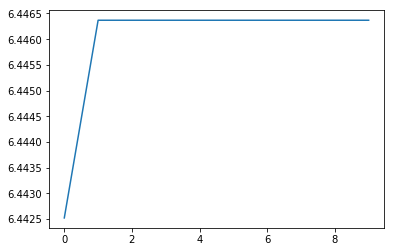

In [69]:
#centroids, clusters, errs = k_means_modified1(X, n_partition, num_iters=10)
centroids, clusters, errs = k_means_modified1_plus(X, n_partition, num_iters=10)

plt.plot(errs)
# compute error function for k-means baseline
print("K-means_ours (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,clusters))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters==i) for i in range(n_partition)]
print(nodes_in_cluster)
#print("The final cluster mean values are:",centroids)

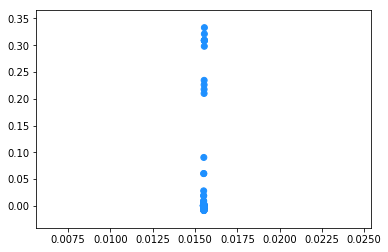

In [70]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])

In the second modification, we start from a standard K-means clustering and then try to distribute the data from the larger cluster to closest cluster with less data.

In [71]:
def k_means_modified2(X, n_partition, num_iters):    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    max_cluster_size = n_data/n_partition
    k_means_errors=[]
    
    #first use standard K-means to get the clusters
    km=KMeans(n_clusters=n_partition,max_iter=5000)
    km.fit(X)
    
    clusters = km.labels_
    
    data_per_cluster = [sum(clusters==i) for i in range(n_partition)]
    k_means_errors.append(obj_func(G,clusters))
    
    for it in range(num_iters):
        print("iteration:",it)
        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(n_data) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        #re-assign clusters
        for i in range(n_data):
            #if data is from big clusters, then re-assign it
            if data_per_cluster[clusters[i]] > max_cluster_size:
                dist_to_cluster = [np.linalg.norm(X[i] - centroids[j]) for j in range(n_partition)]
                close_clusters = np.argsort(dist_to_cluster)
                assigned_flag = False        
                for j in range(n_partition):
                    if  assigned_flag == False and data_per_cluster[close_clusters[j]] < max_cluster_size:
                        data_per_cluster[clusters[i]] -= 1
                        clusters[i] = close_clusters[j]
                        data_per_cluster[close_clusters[j]] += 1
                        assigned_flag = True 
                        continue
                        
        k_means_errors.append(obj_func(G,clusters))
        #print(k_means_errors)

    return centroids,clusters,k_means_errors

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
K-means_ours (baseline) error with 2 dimensions:
6.424242424242424
Number of nodes in each cluster:
[2079, 2079]


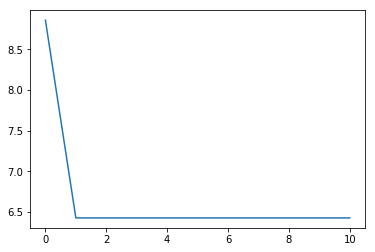

In [72]:
centroids, clusters, errs = k_means_modified2(X, n_partition, num_iters=10)

plt.plot(errs)
# compute error function for k-means baseline
print("K-means_ours (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,clusters))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters==i) for i in range(n_partition)]
print(nodes_in_cluster)
#print("The final cluster mean values are:",centroids)

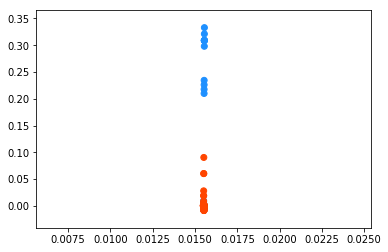

In [73]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])

The third modification changes the definition of distance to a cluster center by weighting the distance with respect to the size of the cluster. This is a regularized K-means which has an open parameter alpha indicating how much we care about balanceness of the data.

In [74]:
def k_means_modified3(X, n_partition, num_iters):    
    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    
    alpha = 0.0045/(n_data*dim)  # TODO: Open parameter, needs to be tuned
    
    #Assign data to random clusters
    clusters = np.array([random.randint(0,n_partition-1) for i in range(n_data)]) 
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)
        
        k_means_errors.append(obj_func(G,clusters))
        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids
        
        data_per_cluster = [np.sum(clusters==i) for i in range(n_partition)]
        #print(data_per_cluster)
        #re-assign clusters
        for i in range(n_data):      
            #the error measure is changed here. rather than dist, we use: dist + alpha*clustersize
            dist_to_cluster = [(np.linalg.norm(X[i] - centroids[j]))+ alpha*data_per_cluster[j] for j in range(n_partition)]
            #if i==1:
            #    print([(np.linalg.norm(X[i] - centroids[j])) for j in range(n_partition)])
            #    print([alpha*data_per_cluster[j] for j in range(n_partition)])
            data_per_cluster[clusters[i]] -= 1
            clusters[i] = np.argmin(dist_to_cluster)
            data_per_cluster[clusters[i]] += 1


    return centroids,clusters,k_means_errors

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
K-means_ours (baseline) error with 2 dimensions:
8.8589001447178
Number of nodes in each cluster:
[12, 4146]


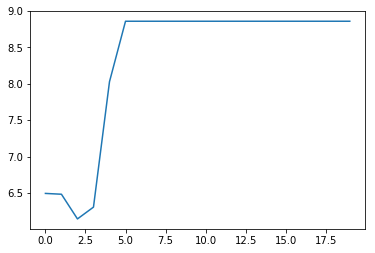

In [75]:
centroids, clusters, errs = k_means_modified3(X, n_partition, num_iters=20)
#TODO: for this the parameter alpha needs to be tuned

plt.plot(errs)
# compute error function for k-means baseline
print("K-means_ours (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,clusters))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters==i) for i in range(n_partition)]
print(nodes_in_cluster)
#print("The final cluster mean values are:",centroids)

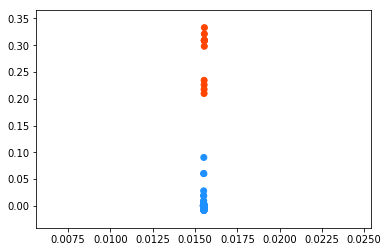

In [76]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])

Considering a priority for each node and then assigning nodes to their clusters based on this priority.

In [24]:
def k_means_modified4_plus(X, n_partition, num_iters):    
    
    
    dim = X.shape[1]
    n_data = X.shape[0]
    max_cluster_size = n_data/n_partition
    
    #Initialize centeriods using ++ method
    centroids = initialize(X, n_partition)
    
    #
    clusters = np.array([0]*n_data)
    
    k_means_errors=[]
    for it in range(num_iters):
        print("iteration:",it)
        
        data_per_cluster = [0.0]*n_partition
        
        dist_to_cluster = np.zeros([n_data,n_partition])
        priority_cluster = np.zeros([n_data,n_partition])
        
        for i in range(n_data):      
            dist_to_cluster[i,:] = [(np.linalg.norm(X[i] - centroids[j])) for j in range(n_partition)]
            for j in range(n_partition):
                priority_cluster[i,j] = dist_to_cluster[i,j] - np.max(dist_to_cluster[i,:])
                
        priority = priority_cluster.min(1)                                         
        high_priority = np.argsort(priority)
            
        
        for i in range(n_data):
            curr_data = high_priority[i]
            data_cluser_priority = np.argsort(priority_cluster[curr_data,:])
            assigned_flag = False  
            for candidate in data_cluser_priority:
                if assigned_flag == False and data_per_cluster[candidate] < max_cluster_size:
                    clusters[curr_data] = candidate
                    data_per_cluster[candidate] += 1
                    assigned_flag = True 
                    continue

        
        #update means
        new_centroids = np.zeros((n_partition,dim))
        for i in range(n_partition):
            cluster_points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
            if len(cluster_points) != 0:
                new_centroids[i] = np.mean(cluster_points, axis = 0)
        centroids = new_centroids

        #k_means_errors.append(obj_func(G,clusters))

    return centroids,clusters,k_means_errors

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
K-means_ours (baseline) error with 2 dimensions:
6.462722462722462
Number of nodes in each cluster:
[2079, 2079]


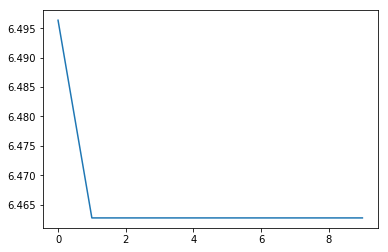

In [78]:
centroids, clusters, errs = k_means_modified4_plus(X, n_partition, num_iters=10)


plt.plot(errs)
# compute error function for k-means baseline
print("K-means_ours (baseline) error with", X.shape[1], "dimensions:")
print(obj_func(G,clusters))
print("Number of nodes in each cluster:")
nodes_in_cluster = [sum(clusters==i) for i in range(n_partition)]
print(nodes_in_cluster)
#print("The final cluster mean values are:",centroids)

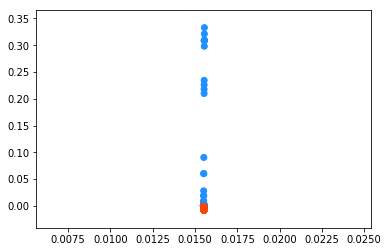

In [79]:
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])

## Toy example

Let's create some simulated data and compare the method:

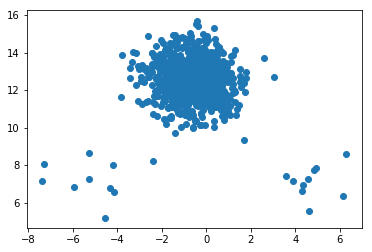

In [73]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[700, 100, 10], centers=None, n_features=2,random_state=5)
X[:800] += 5
plt.scatter(X[:,0],X[:,1])

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
Number of nodes in each cluster or modified K-means:
[270, 270, 270]


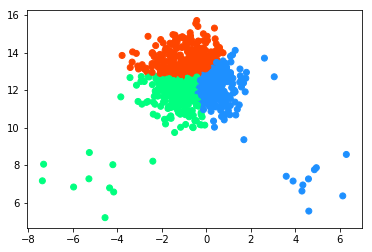

In [81]:
K=3

centroids, clusters, errs = k_means_modified4_plus(X, K, num_iters=10)
print("Number of nodes in each cluster or modified K-means:")
nodes_in_cluster = [sum(clusters==i) for i in range(K)]
print(nodes_in_cluster)
data_colors = ['orangered','dodgerblue','springgreen']
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in clusters])


Number of nodes in each cluste for standard K-means:
[325, 474, 11]


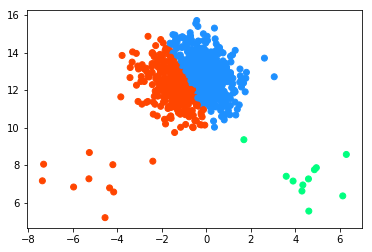

In [80]:
# Computing k-means
km=KMeans(n_clusters=K,max_iter=5000) #, init="k-means++",n_init=100
km.fit_predict(X)

# compute error function for k-means baseline
print("Number of nodes in each cluste for standard K-means:")
nodes_in_cluster = [sum(km.labels_==i) for i in range(K)]
print(nodes_in_cluster)
plt.scatter(X[:,0], X[:,1], c=[data_colors[i] for i in km.labels_])